## Import Library

In [1]:
import os
import sys

# Menonaktifkan log TensorFlow (hanya menampilkan ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # '0' (default), '1' (INFO), '2' (WARNING), '3' (ERROR)

# Menonaktifkan log CUDA/NVIDIA terkait NUMA
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Pilih GPU tertentu atau kosongkan (' ') untuk hanya pakai CPU
os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'false'
os.environ['NVIDIA_LOGS'] = '0'

# Menonaktifkan stderr untuk menyembunyikan log tambahan dari TensorFlow dan CUDA
sys.stderr = open(os.devnull, 'w')

import re
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score,  classification_report

from catboost import CatBoostClassifier

import optuna
import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout, Input, BatchNormalization


I0000 00:00:1743261569.443277  227558 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1743261569.819089  227558 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1743261569.819317  227558 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1743261569.829673  227558 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1743261569.829881  227558 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

## 1. Business Understanding

Projek ini menggunakan data dari Review Play Store untuk Aplikasi Brimo. Hal ini saya pilih mengingat tingginya penggunaan aplikasi ini di kalangan masyarakat, khususnya Mahasiswa, yang saya rasakan sendiri. Tingginya pengguna tentu tidak akan terlepas dari penilaian baik hingga buruk dari masyarakat. Berdasarkan kondisi tersebut diperlukannya sebuah metode yang dapat mengetahui sentimen masyarakat terkait aplikasi Brimo. 

Dataset yang digunakan merupakan hasil scrapping langsung dari aplikasi Playstore. Proses scrapping dilakukan dengan python melalui libraary *google play scrapper*. 

Dalam mengetahui sentimen masyarakat terkait aplikasi Brimo, digunakan pemodelan klasifikasi yang diikuti dengan pemrosesan teks review hingga dapat dijadikan input untuk sebuah model. Penelitian ini akan menerapkan model *Machine Learning* dan *Deep Learning* untuk meninjau pendekatan mana yang memberikan hasil lebih baik.

## 2. Data Understanding

### Scrapping Review Playstore : Brimo

In [2]:
import os
import pandas as pd

nama_file = "Hasil Scrapping Review Playstore.csv"

# Cek apakah file ada
if not os.path.exists(nama_file) or pd.read_csv(nama_file).empty:
    from google_play_scraper import reviews_all

    package_name = "id.co.bri.brimo"

    # Ambil semua ulasan
    result = reviews_all(
        package_name,
        sleep_milliseconds=10,
        lang="id",
        country="id"
    )

    # Pilih hanya kolom yang dibutuhkan
    filtered_reviews = [
        {
            "reviewId": r["reviewId"],
            "content": r["content"],
            "score": r["score"],
            "thumbsUpCount": r["thumbsUpCount"]
        }
        for r in result
    ]

    # Konversi ke DataFrame
    df = pd.DataFrame(filtered_reviews)

    # Simpan ke CSV
    df.to_csv(nama_file, index=False, encoding="utf-8")

    print(f'Berhasil mengambil {len(df)} ulasan dan disimpan di {nama_file}')
else:
    print(f"File {nama_file} sudah ada dan tidak kosong. Tidak perlu scraping ulang.")


File Hasil Scrapping Review Playstore.csv sudah ada dan tidak kosong. Tidak perlu scraping ulang.


In [3]:
dataset = pd.read_csv("Hasil Scrapping Review Playstore.csv")

### Pendefinisian fungsi pengecekan distribusi data

In [ ]:
def cek_distribusi_label(df, label_column):
    if label_column not in df.columns:
        raise ValueError(f"Kolom '{label_column}' tidak ditemukan dalam DataFrame")
    
    distribusi = df[label_column].value_counts()
    persentase = df[label_column].value_counts(normalize=True) * 100
    
    distribusi_df = pd.DataFrame({'Jumlah': distribusi, 'Persentase': persentase})
    return distribusi_df

### Pengecekan distribusi data untuk setiap label

In [5]:
distribusiLabel = cek_distribusi_label(dataset, "score")
print(distribusiLabel)

       Jumlah  Persentase
score                    
5      235502   74.762540
1       40003   12.699365
4       19656    6.240000
3       10327    3.278413
2        9512    3.019683


**Penjelasan** : <br>
Dalam mengeksplorasi data yang digunakan, dilakukan pengecekan distribusi label berdasarkan kolom *score review* pada setiap komentar. Hal ini dapat menunjukkan indikasi sentimen sebelum dilakukan pelabelan. Hal ini dapat berguna untuk meninjau kondisi *imbalanced* pada data yang digunakan. Pada output tersebut terlihat bahwa komentar didominasi oleh sentimen positif. Selain itu distribusi pada label lain masih terlihat sehingga seharusnya variasi pada sentimen lain masih dapat dijelaskan oleh data yang tersedia.

## 3. Data Preparation (Preprocessing Data)

### Pendefinisian Teknik Labelling berbasis Lexicon

In [ ]:
# 1. Load lexicon dari TSV
positive_lexicon = pd.read_csv("Lexicon/positive.tsv", sep="\t")
negative_lexicon = pd.read_csv("Lexicon/negative.tsv", sep="\t")

# 2. Konversi ke dictionary {word: weight}
pos_dict = dict(zip(positive_lexicon["word"], positive_lexicon["weight"]))
neg_dict = dict(zip(negative_lexicon["word"], negative_lexicon["weight"]))

# 3. Fungsi untuk menghitung skor sentimen
def label_text(text):
    words = text.lower().split()  # Tokenisasi sederhana
    score = sum(pos_dict.get(word, 0) for word in words) + sum(neg_dict.get(word, 0) for word in words)

    if score > 0:
        return "Positif"
    elif score < 0:
        return "Negatif"
    else:
        return "Netral"


**Penjelasan** : <br>
Pelabelan yang digunakan pada dataset menggunakan pelabelan berbasis lexicon. Kumpulan token positif dan negatif diperoleh dari InSet yang merupakan dictionary lexicon berbahasa Indonesia. Pada file tersebut terdapat kata disertai bobot yang nantinya berguna untuk menentukan suatu kalimat dilabeli positif, negatif, atau netral.

### Text Preprocessing : Casefolding

In [7]:
def casefolding(text):
    """Mengubah teks menjadi huruf kecil"""
    return text.lower()

### Text Preprocessing : Menghapus Angka

In [ ]:
# Fungsi untuk menghapus angka dari teks
def hapus_angka(teks):
    if isinstance(teks, str):  # Pastikan hanya string yang diproses
        return ''.join([char for char in teks if not char.isdigit()])
    return teks  # Kembalikan nilai asli jika bukan string

### Text Preprocessing : Menghapus Tanda Baca

In [ ]:
# Fungsi untuk menghapus tanda baca dari teks
def remove_punctuation(teks):
    if isinstance(teks, str):  # Pastikan hanya string yang diproses
        punctuation_set = set(string.punctuation)
        return ''.join(char for char in teks if char not in punctuation_set)
    return teks  # Kembalikan nilai asli jika bukan string

### Text Preprocessing : Eliminasi Whitespace

In [ ]:
def remove_whitespace(text):
    """Menghapus whitespace ekstra dalam teks"""
    return ' '.join(text.split())

### Text Preprocessing : Tokenisasi

In [ ]:
def tokenize(text):
    """Memecah teks menjadi token (kata-kata)"""
    return re.findall(r'\b\w+\b', text)

### Text Preprocessing : Stemming (Menghilangkan imbuhan)

In [ ]:
# Inisialisasi stemmer dan stopword remover
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(text):
    """Melakukan stemming pada setiap kata dalam teks"""
    return ' '.join(stemmer.stem(word) for word in tokenize(text))

### Text Preprocessing : Eliminasi Stopwords

In [ ]:

# Unduh stopwords tambahan jika belum diunduh
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

stopword_factory = StopWordRemoverFactory()
stopwords_sastrawi = set(stopword_factory.get_stop_words())
stopwords_nltk = set(stopwords.words('indonesian'))
stopwords_combined = stopwords_sastrawi.union(stopwords_nltk)
def remove_stopwords(text):
    return ' '.join(word for word in tokenize(text) if word not in stopwords_combined)


### Text Preprocessing Keseluruhan

In [14]:
# 4. Fungsi preprocessing teks
def preprocess_text(data, column, label):
    data[column] = data[column].astype(str).apply(casefolding)
    data[column] = data[column].apply(remove_whitespace)
    data[column] = data[column].apply(hapus_angka)
    data[column] = data[column].apply(remove_punctuation)    
    data[column] = data[column].apply(stemming)
    data[column] = data[column].apply(remove_stopwords)
    if label == True:
        # Tambahkan kolom sentimen sebelum stemming dan remove stopword
        data["sentimen"] = data[column].apply(label_text)
    return data

# Contoh penggunaan
datasetClean = preprocess_text(dataset, 'content', True)

# Mengambil hanya kolom reviewsId dan sentimen dari datasetClean
datasetSentimen = datasetClean[['reviewId', 'sentimen']]

# Merge dataset dengan datasetSentimen berdasarkan reviewsId
datasetBaru = dataset.merge(datasetSentimen, on='reviewId', how='left')

# Menampilkan 10 data pertama
datasetClean = preprocess_text(dataset, 'content', False)




**Penjelasan** : <br>
Pemrosesan text melibatkan beberapa tahapan yang dimulai dengan *casefolding*. Proses ini bertujuan untuk mengubah seluruh karakter pada lowercase sehingga dapat menghilangkan perbedaan teks karena jenis karakter (upcase dan lowercase). Tahapan selanjutnya adalah *remove whitespace*. Tahapan ini bertujuan untuk menghilangkan spasi berlebih pada kata. Hal ini bertujuan untuk menghilangkan elemen tidak penting pada kalimat. <br>

Tahapan selanjutnya adalah *remove punctuation* yang bertujuan untuk menghilangkan tanda baca pada kalimat, karena pada dasarnya tanda baca cenderung tidak mempengaruhi sentimen pada suatu kalimat. Tahapan selanjutnya adalah *stemming*. Tahapan ini berguna untuk mengekstrak kata dasar di sebuah kalimat dengan mengeliminasi imbuhan. Hal ini merupakan tahapan yang berguna untuk menyederhanakan suatu kalimat. Selanjutnya adalah *remove stopword*. Tahapan ini berguna untuk menghilangkan kata yang sering muncul pada suatu kalimat berdasarkan kamus bahasa dari NLTK. <br>
Tahapan terakhir adalah pelabelan berbasis lexicon.

### Visualisasi Hasil Sentimen

In [15]:
def vizWordcloud(df, text_column, label_column):
    labels = df[label_column].unique()
    fig, axes = plt.subplots(len(labels), 1, figsize=(7, 4 * len(labels)), constrained_layout=True)
    
    if len(labels) == 1:
        axes = [axes]
    
    for ax, label in zip(axes, labels):
        text = " ".join(df[df[label_column] == label][text_column].astype(str))
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f"WordCloud - {label}", pad=5)
        ax.axis("off")
    
    plt.show()

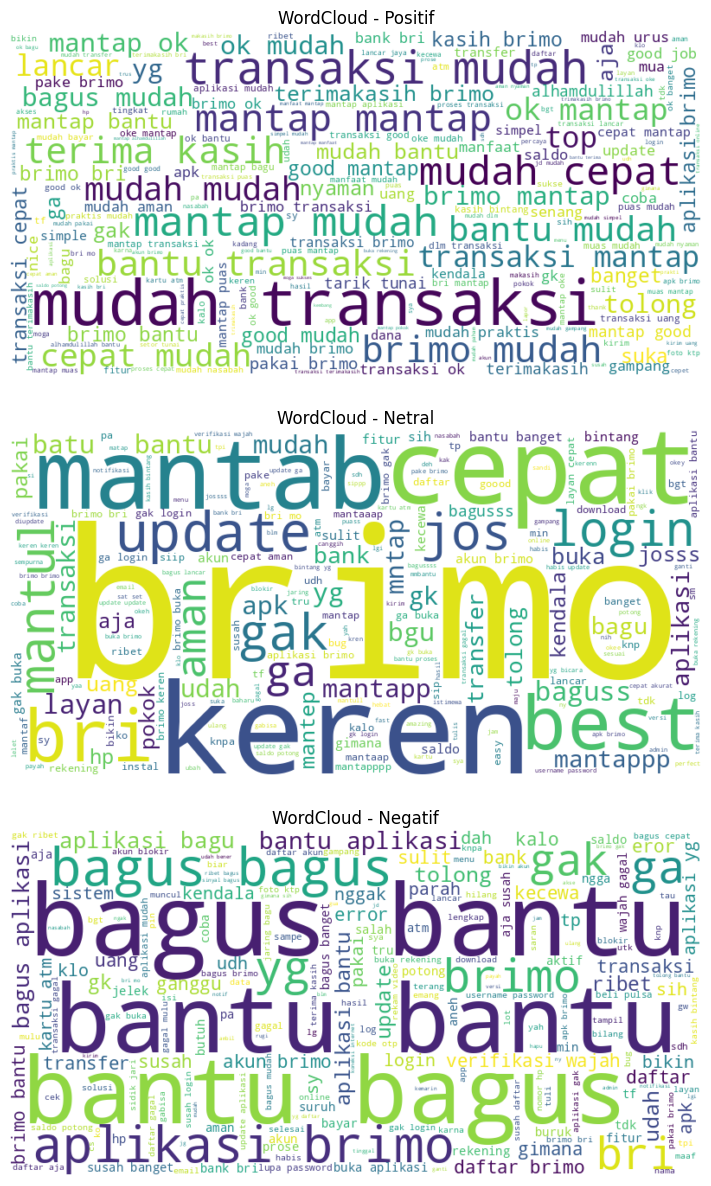

In [16]:
vizWordcloud(datasetClean, "content", "sentimen")

**Penjelasan** : <br>
Berdasarkan visualisasi wordcloud yang dibentuk, terlihat bahwa sentimen positif didominasi kata 'mudah', 'transaksi', dan 'cepat'. Hal ini terjadi jika kata tersebut memiliki jumlah yang mendominasi kalimat sehingga bobot akhir bernilai positif. Visualisasi wordcloud untuk sentimen netral didominasi kata 'mantab', 'cepat', 'keren', 'brimo'. Kondisi ini dapat terjadi karena kata di dalam kalimat itu cenderung memiliki bobot positif dan negatif sehingga skor akhir mendekati 0. Pada wordcloud negatif, terlihat bahwa kata yang mendominasi adalah 'bantu', 'bagus', 'aplikasi'.

### Membuat Folder Output

In [17]:
os.makedirs('Running Model')

### Pendefinisian Fungsi Memperoleh Vektor Kalimat

In [18]:
def getVektorKalimat(sentence, model):
    vectors = [model.wv[word] for word in sentence.split() if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

### Splitting Data

In [19]:
def persiapanData(datasetClean, skema):
    # Split data
    x_train, x_test, y_train, y_test = train_test_split(datasetClean['content'], datasetClean['sentimen'], stratify=datasetClean['sentimen'], test_size=0.2, random_state=42)
    
    if skema['ekstraksiFitur'] == 1 and skema['model'] == 1:
        vectorizer = TfidfVectorizer()
        
        # Fit dan transform data training
        x_train_baru = vectorizer.fit_transform(x_train)
        x_test_baru = vectorizer.transform(x_test)
        
        # Simpan vectorizer dengan nama sesuai skema
        joblib.dump(vectorizer, f"Running Model/tfidf_vectorizer_{skema['nama']}.pkl")
    else:
        # Tokenisasi untuk Word2Vec
        tokenized_sentences = [sentence.split() for sentence in datasetClean['content']]
        embedding_dim = 100 # Vector Size untuk Word2Vec sekaligus layer embbeding di BiLSTM
        
        # Latih model Word2Vec
        word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)
        
        # Simpan model Word2Vec dengan nama sesuai skema
        word2vec_model.save(f"word2vec_model_{skema['nama']}.model")

        # Konversi data ke vektor menggunakan Word2Vec
        x_train_baru = np.array([getVektorKalimat(sentence, word2vec_model) for sentence in x_train])
        x_test_baru = np.array([getVektorKalimat(sentence, word2vec_model) for sentence in x_test]) 
        
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)  
    y_test = label_encoder.transform(y_test)
    
    # Simpan label encoder dengan nama sesuai skema
    joblib.dump(label_encoder, f"label_encoder_{skema['nama']}.pkl")
    
    # Tampilkan pemetaan label encoding
    label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Label Mapping:", label_mapping) 
    
    if skema['model'] == 2:
        # Sesuaikan input untuk LSTM: (samples, timesteps, features)
        X_train = x_train_baru.reshape((x_train_baru.shape[0], 1, x_train_baru.shape[1]))
        X_test = x_test_baru.reshape((x_test_baru.shape[0], 1, x_test_baru.shape[1]))

        # Cek bentuk akhir
        print(X_train.shape)
        print(X_test.shape)
    else:
        X_train = x_train_baru
        X_test = x_test_baru
    
    return X_train, X_test, y_train, y_test

## 4. Modelling

### Pendefinisian Model Catboost dan BiLSTM

In [20]:
def modellingSkema(skema, X_train, X_test, y_train, y_test, save_path="Running Model/"):
    results = []
    print(f"========Running Model untuk Skema Pengujian : {skema['nama']}==========")
    
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    if skema['model'] == 1:
        def objective(trial):
            iterations = trial.suggest_int("iterations", 100, 1000)
            learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
            l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 1e-3, 10)
            print(f"🔎 Trial {trial.number}: iterations={iterations}, learning_rate={learning_rate:.4f}, l2_leaf_reg={l2_leaf_reg:.4f}")
            model = CatBoostClassifier(
                iterations=iterations,
                learning_rate=learning_rate,
                l2_leaf_reg=l2_leaf_reg,
                verbose=0,
                random_seed=42
            )
            
            model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=10, verbose=0)
            y_pred = model.predict(X_test)
            return f1_score(y_test, y_pred, average='macro')
        
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=15)
        best_params = study.best_params
        
        best_model = CatBoostClassifier(**best_params, verbose=0, random_seed=42)
        best_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=10, verbose=0)
        
        # Save model CatBoost
        model_path = f"{save_path}catboost_{skema['nama']}.cbm"
        best_model.save_model(model_path)
        print(f"Model CatBoost disimpan di: {model_path}")

        y_pred_train = best_model.predict(X_train)
        y_pred_test = best_model.predict(X_test)
    
    else:
        model = Sequential([
            Input(shape=(X_train.shape[1], X_train.shape[2])),
            Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
            Bidirectional(LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(3, activation='softmax')
        ])

        print("Compile Model : ")
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=256, verbose=1)
        
        # Save model LSTM
        model_path = f"{save_path}lstm_{skema['nama']}.h5"
        model.save(model_path)
        print(f"Model LSTM disimpan di: {model_path}")

        y_pred_train = np.argmax(model.predict(X_train), axis=1)
        y_pred_test = np.argmax(model.predict(X_test), axis=1)
    
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1_macro = f1_score(y_train, y_pred_train, average='macro')
    train_balanced_acc = balanced_accuracy_score(y_train, y_pred_train)
    print("\nClassification Report Train : ")
    print(classification_report(y_train, y_pred_train))

    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1_macro = f1_score(y_test, y_pred_test, average='macro')
    test_balanced_acc = balanced_accuracy_score(y_test, y_pred_test)
    print("\nClassification Report Test : ")
    print(classification_report(y_test, y_pred_test))

    results.append({
        'Skema Pengujian': skema['nama'],
        'Train Accuracy': train_accuracy,
        'Train F1 Score (Macro)': train_f1_macro,
        'Train Balanced Accuracy': train_balanced_acc,
        'Test Accuracy': test_accuracy,
        'Test F1 Score (Macro)': test_f1_macro,
        'Test Balanced Accuracy': test_balanced_acc,
        'Model Path': model_path
    })
    
    return results


## Pendefinisian Skema Pengujian

In [21]:
skema = [{
'nama' : 'Pemodelan Catboost dengan TF-IDF',
'ekstraksiFitur' : 1,
'model' : 1
},{
'nama' : 'Pemodelan Catboost dengan Word2Vec',
'ekstraksiFitur' : 2,
'model' : 1
},{
'nama' : 'Pemodelan BiLSTM dengan Word2Vec',
'ekstraksiFitur' : 2,
'model' : 2    
}]

hasilFinal = []

**Penjelasan Skema Pengujian**:<br>
Skema pengujian yang akan dilakukan melibatkan 4 kombinasi dari 2 parameter skema yaitu ekstraksiFitur untuk 2 kemungkinan dan model untuk 2 kemungkinan. ekstraksiFitur yang akan diujikan yaitu menggunakan *Term Frequency-Inverse Document Frequency* (TF-IDF) dan Word2Vec. Model yang akan digunakan dan sekaligus untuk dibandingkan adalah model Machine Learning dengan Category Boosting (CatBoost) dan Deep Learning yaitu BiLSTM. Pemilihan kedua metode didasari pada kemampuannya dalam memberikan hasil optimal pada *task* klasifikasi. <br>


Model Catboost yang dibangun dioptimasi dengan library optuna yang merupakan tahapan *hyperparameter tuning*. Hal ini digunakan agar memperoleh kombinasi optimal pada pembentukan model CatBoost. Optuna menggunakan algoritma TPE yang pada penelitian ini, jumlah trial didefinisikan sebanyak 15 dengan mempertimbangkan jumlah dataset dan beban komputasi. <nr>

Model BiLSTM yang dibangun menggunakan optimizer Adam dengan learning rate default pada optimizer tersebut. Selain itu digunakan juga 2 layer BiLSTM yang dilanjutkan dengan Fully Connected Layer melalui layer Dense.

## Main Program

### Skema 1

In [22]:
X_train, X_test, y_train, y_test = persiapanData(datasetClean, skema[0])
result = modellingSkema(skema[0], X_train, X_test, y_train, y_test)
hasilFinal.extend(result)

Label Mapping: {'Negatif': 0, 'Netral': 1, 'Positif': 2}
========Running Model untuk Skema Pengujian : Pemodelan Catboost dengan TF-IDF==========
🔎 Trial 0: iterations=690, learning_rate=0.1156, l2_leaf_reg=4.6537
🔎 Trial 1: iterations=745, learning_rate=0.1713, l2_leaf_reg=2.7309
🔎 Trial 2: iterations=956, learning_rate=0.1152, l2_leaf_reg=2.2715
🔎 Trial 3: iterations=361, learning_rate=0.0584, l2_leaf_reg=7.9168
🔎 Trial 4: iterations=996, learning_rate=0.1250, l2_leaf_reg=8.6971
🔎 Trial 5: iterations=454, learning_rate=0.1805, l2_leaf_reg=0.8935
🔎 Trial 6: iterations=224, learning_rate=0.2639, l2_leaf_reg=2.3611
🔎 Trial 7: iterations=528, learning_rate=0.1189, l2_leaf_reg=5.3373
🔎 Trial 8: iterations=328, learning_rate=0.1749, l2_leaf_reg=8.4304
🔎 Trial 9: iterations=837, learning_rate=0.0242, l2_leaf_reg=6.2038
🔎 Trial 10: iterations=725, learning_rate=0.2508, l2_leaf_reg=0.0115
🔎 Trial 11: iterations=701, learning_rate=0.2611, l2_leaf_reg=0.2676
🔎 Trial 12: iterations=709, learning

### Skema 2

In [23]:
X_train, X_test, y_train, y_test = persiapanData(datasetClean, skema[1])
result = modellingSkema(skema[1], X_train, X_test, y_train, y_test)
hasilFinal.extend(result)

Label Mapping: {'Negatif': 0, 'Netral': 1, 'Positif': 2}
========Running Model untuk Skema Pengujian : Pemodelan Catboost dengan Word2Vec==========
🔎 Trial 0: iterations=309, learning_rate=0.0154, l2_leaf_reg=5.3534
🔎 Trial 1: iterations=188, learning_rate=0.2298, l2_leaf_reg=7.2155
🔎 Trial 2: iterations=419, learning_rate=0.1750, l2_leaf_reg=4.0262
🔎 Trial 3: iterations=297, learning_rate=0.1037, l2_leaf_reg=2.8361
🔎 Trial 4: iterations=493, learning_rate=0.2099, l2_leaf_reg=7.7644
🔎 Trial 5: iterations=863, learning_rate=0.2347, l2_leaf_reg=9.9335
🔎 Trial 6: iterations=459, learning_rate=0.1577, l2_leaf_reg=5.1725
🔎 Trial 7: iterations=174, learning_rate=0.0891, l2_leaf_reg=1.2692
🔎 Trial 8: iterations=705, learning_rate=0.1608, l2_leaf_reg=6.2052
🔎 Trial 9: iterations=126, learning_rate=0.2182, l2_leaf_reg=1.5079
🔎 Trial 10: iterations=981, learning_rate=0.2796, l2_leaf_reg=9.5453
🔎 Trial 11: iterations=984, learning_rate=0.2987, l2_leaf_reg=9.9592
🔎 Trial 12: iterations=1000, learn

### Skema 3

In [24]:
X_train, X_test, y_train, y_test = persiapanData(datasetClean, skema[2])
result = modellingSkema(skema[2], X_train, X_test, y_train, y_test)
hasilFinal.extend(result)

Label Mapping: {'Negatif': 0, 'Netral': 1, 'Positif': 2}
(252000, 1, 100)
(63000, 1, 100)
========Running Model untuk Skema Pengujian : Pemodelan BiLSTM dengan Word2Vec==========
Compile Model : 
Epoch 1/25
985/985 ━━━━━━━━━━━━━━━━━━━━ 120s 109ms/step - accuracy: 0.8072 - loss: 0.4860 - val_accuracy: 0.8957 - val_loss: 0.2720
Epoch 2/25
985/985 ━━━━━━━━━━━━━━━━━━━━ 85s 87ms/step - accuracy: 0.8835 - loss: 0.3088 - val_accuracy: 0.9013 - val_loss: 0.2589
Epoch 3/25
985/985 ━━━━━━━━━━━━━━━━━━━━ 80s 81ms/step - accuracy: 0.8908 - loss: 0.2916 - val_accuracy: 0.9070 - val_loss: 0.2441
Epoch 4/25
985/985 ━━━━━━━━━━━━━━━━━━━━ 81s 82ms/step - accuracy: 0.8963 - loss: 0.2775 - val_accuracy: 0.9108 - val_loss: 0.2358
Epoch 5/25
985/985 ━━━━━━━━━━━━━━━━━━━━ 81s 82ms/step - accuracy: 0.8989 - loss: 0.2714 - val_accuracy: 0.9138 - val_loss: 0.2301
Epoch 6/25
985/985 ━━━━━━━━━━━━━━━━━━━━ 81s 83ms/step - accuracy: 0.9000 - loss: 0.2663 - val_accuracy: 0.9116 - val_loss: 0.2287
Epoch 7/25
985/985 ━━━

## 5. Evaluation

In [25]:
pd.DataFrame(hasilFinal)

,Skema Pengujian,Train Accuracy,Train F1 Score (Macro),Train Balanced Accuracy,Test Accuracy,Test F1 Score (Macro),Test Balanced Accuracy,Model Path
0,Pemodelan Catboost dengan TF-IDF,0.968687,0.961679,0.961700,0.962206,0.954772,0.954921,Running Model/catboost_Pemodelan Catboost deng...
1,Pemodelan Catboost dengan Word2Vec,0.953036,0.948595,0.944236,0.923984,0.917708,0.913209,Running Model/catboost_Pemodelan Catboost deng...
2,Pemodelan BiLSTM dengan Word2Vec,0.932643,0.927238,0.922361,0.928063,0.922298,0.917332,Running Model/lstm_Pemodelan BiLSTM dengan Wor...


**Penjelasan** : <br>
Berdasarkan model yang dibangun serta hasil evaluasi yang diperoleh, terlihat bahwa skema 1 memberikan hasil terbaik. Hal ini ditandai dengan ukuran evaluasi Akurasi, F1-Score, dan BalanceAccuracy pada training set dan testing set lebih tinggi dari skema lainnya. Kondisi ini juga mengindikasikan bahwa model dilatih dengan baik, yang ditandai dengan perbedaan yang minim antara evaluasi pada training set dan testing set sehingga tidak ada kecenderungan *overfitting*.

Selain itu pada penggunaan ekstraksi fitur dengan TF-IDF memberikan hasil yang lebih baik dibanding Word2Vec seperti yang terlihat pada Skema 1 dan Skema 2. Dengan menggunakan algoritma machine learning yang sama, terdapat perbedaan evaluasi pada kedua skema. Hal ini dapat terjadi karena TF-IDF menggunakan seluruh token pada data, sedangkan pada Word2Vec terdapat pembatasan berupa besaran vector yang ditetapkan pada penelitian ini dengan mempertimbangkan beban komputasi karena ukuran dataset yang besar.

Secara keseluruhan model yang dibangun pada ketiga skema memberikan hasil yang bagus, terlihat pada nilai akurasi ketiga skema lebih dari 92%. Kondisi ini dapat ditingkatkan dengan menggunakan mekanisme seperti *majority voting* ataupun implementasi model pretrained seperti IndoBERT dalam pembentukan model klasifikasi. Selain itu penggunaan mekanisme pelabelan lain juga dapat memberikan perubahan pada hasil model yang dibangun.

## 6. Deployment

In [28]:
def preprocess_text_input(text):
    text = casefolding(text)
    text = remove_whitespace(text)
    text = hapus_angka(text)
    text = remove_punctuation(text)
    text = stemming(text)
    text = remove_stopwords(text)
    return text

# Load model dan vectorizer
model = CatBoostClassifier()
model.load_model("Running Model/catboost_Pemodelan Catboost dengan TF-IDF.cbm")
vectorizer = joblib.load("Running Model/tfidf_vectorizer_Pemodelan Catboost dengan TF-IDF.pkl")

# Label mapping
label_mapping = {0: 'Negatif', 1: 'Netral', 2: 'Positif'}

def predict_from_input():
    user_input = input("Masukkan teks untuk prediksi: ")
    
    # Preprocessing input pengguna
    processed_text = preprocess_text_input(user_input)
    
    # Transformasi teks ke vektor TF-IDF
    text_tfidf = vectorizer.transform([processed_text])
    
    # Lakukan prediksi dengan model
    prediction = model.predict(text_tfidf)
    
    # Konversi hasil prediksi ke label
    predicted_label = label_mapping[int(prediction[0])]
    
    print(f"Teks yang dimasukkan: {user_input}")
    print(f"Hasil prediksi: {predicted_label}")

predict_from_input()

Teks yang dimasukkan: Aplikasinya ribet banget makenya, mending pake wondr atau blu
Hasil prediksi: Negatif
